In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import arviz as az

import sys, importlib
from FetchModel import FetchModel
from PostPred import PostPred
importlib.reload(sys.modules['FetchModel'])
importlib.reload(sys.modules['PostPred'])
from FetchModel import FetchModel
from PostPred import PostPred

In [2]:
Y = pd.read_csv("../Datasets/Dataset_180.csv")
Y['Count_180'] = pd.to_numeric(Y['Count_180']).astype('Int64')
X = pd.read_csv("../Datasets/variables_to_select.csv")
X_raw = pd.read_csv("../Datasets/covariates.csv")

In [3]:
idx_obs = Y[Y['Count_180'].notna()].index
idx_miss = Y[Y['Count_180'].isna()].index

Y_obs = Y.loc[idx_obs, :].reset_index(drop=True)
Y_miss = Y.loc[idx_miss, :].reset_index(drop=True)

X_obs = X.loc[idx_obs, :].reset_index(drop=True)
X_miss = X.loc[idx_miss, :].reset_index(drop=True)

In [4]:
stations = Y['idSensore']
years = pd.Series(Y['Year'] - 2009)
months = pd.Series(Y['Month'] - 3)
unique_values = sorted(set(stations))
mapping_dict = {value: index + 1 for index, value in enumerate(unique_values)}
transformed_stations = [mapping_dict[value] for value in stations]
stations_original = pd.Series(stations)
stations = pd.Series(transformed_stations)

stations_obs = stations.loc[idx_obs].reset_index(drop=True)
stations_miss = stations.loc[idx_miss].reset_index(drop=True)
years_obs = years.loc[idx_obs].reset_index(drop=True)
years_miss = years.loc[idx_miss].reset_index(drop=True)
months_obs = months.loc[idx_obs].reset_index(drop=True)
months_miss = months.loc[idx_miss].reset_index(drop=True)


day_in_month = [31,28,31,30,31,30,31,31,30,31,30,31]

max_month = [day_in_month[Y['Month'][i]-1] for i in range(0,Y.shape[0]) ]

max_month = pd.Series(max_month)
max_month_obs = max_month.loc[idx_obs].reset_index(drop=True)
max_month_miss = max_month.loc[idx_miss].reset_index(drop=True)

In [5]:
Model_metrics = pd.DataFrame(columns=['WAIC', 'LOO', 'MSE', 'MAE', 'MAD', 'inside CI'])

# Base Model

In [6]:
model_base  = FetchModel("base").compile()

In [7]:
data_base = {
    "N": len(Y_obs),
    "P": X_obs.shape[1],
    "y": Y_obs['Count_180'],
    "X": X_obs
}

fit_base = model_base.sample(data=data_base, chains=4, parallel_chains=4, 
    iter_warmup=1000, iter_sampling=1000)
posterior_180_base = az.from_cmdstanpy(fit_base)

11:48:53 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:50:34 - cmdstanpy - INFO - CmdStan done processing.


In [8]:
post_pred = PostPred(posterior_180_base, Y['Count_180'])
Y_data = post_pred.Y

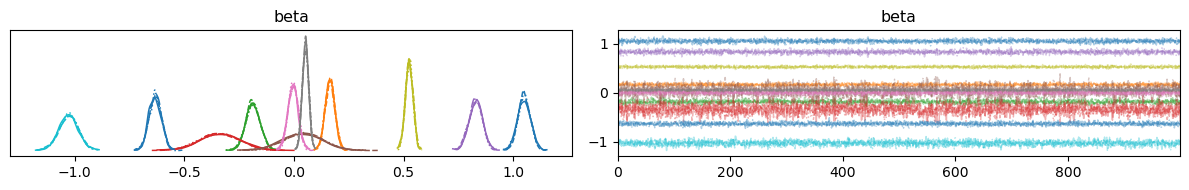

In [9]:
az.plot_trace(post_pred.posterior_az, var_names = ['beta'])
plt.tight_layout()
plt.show()

In [10]:
waic_out = az.waic(post_pred.posterior_az, var_name='log_lik')
loo_out = az.loo(post_pred.posterior_az, var_name='log_lik')
waic = waic_out.elpd_waic
loo = loo_out.elpd_loo
print(waic_out)
print(loo_out)

C:\Users\39339\anaconda3\lib\site-packages\arviz\stats\stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


Computed from 4000 posterior samples and 3808 observations log-likelihood matrix.

          Estimate       SE
elpd_waic -5431.95   117.31
p_waic       36.04        -

There has been a warning during the calculation. Please check the results.
Computed from 4000 posterior samples and 3808 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -5432.00   117.32
p_loo       36.10        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     3808  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%



In [11]:
alpha = 0.05
y_pred, metrics = post_pred.predict(CI=True,
                                       alpha = alpha,
                                       error_metrics = True)

In [12]:
y_obs, residuals, mse, mae, mad, outliers, percentage_inside = metrics.values()
print(f'Outliers:\n{outliers}\n')
print(f'The total number of outliers is: {len(outliers)}\n')
print(f'The MSE is: {mse}\n')
print(f'The MAE is: {mae}\n')
print(f'The MAD is: {mad}\n')
print(f'The percentage of observations inside the CI is: {percentage_inside}\n')

Outliers:
[   2   36   37   51   74   84   85  100  150  155  193  225  238  324
  330  331  346  347  372  376  378  383  384  389  390  402  403  475
  496  516  523  566  580  587  599  600  601  602  607  613  620  621
  622  628  630  634  636  642  643  644  649  656  676  677  723  753
  766  778  791  798  829  835  851  867  872  873  874  907  914  925
  931  932  944  950  951  955  956  957  963  969  970  977  983  990
  991  992  998 1038 1049 1050 1057 1058 1063 1064 1070 1071 1072 1077
 1093 1094 1112 1113 1114 1120 1122 1126 1128 1133 1134 1135 1156 1168
 1202 1203 1204 1217 1218 1366 1378 1379 1380 1392 1419 1427 1468 1539
 1545 1558 1559 1560 1566 1567 1568 1571 1572 1573 1574 1580 1581 1582
 1658 1709 1710 1715 1716 1742 1743 1749 1754 1761 1768 1773 1774 1779
 1780 1781 1794 1800 1821 1832 1854 1878 1908 1921 1935 2031 2045 2051
 2052 2068 2074 2080 2081 2082 2093 2094 2095 2107 2108 2110 2127 2135
 2136 2152 2158 2165 2171 2193 2216 2240 2295 2314 2318 2331 2338 2

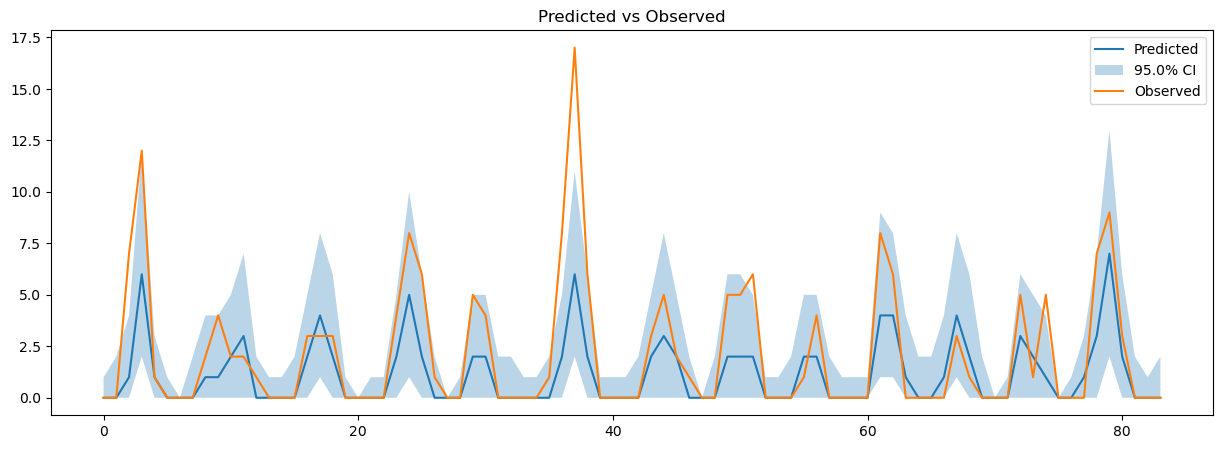

In [13]:
station_num_to_plot = 1 # Change this to plot a different station, -1 to plot manually
if station_num_to_plot != -1:
    xx = np.arange(12*7*(station_num_to_plot-1), 12*7*station_num_to_plot)
else:
    xx = np.arange(1000, 1200) # Change this for the range of the manual choice
plt.figure(figsize=(15, 5))
plt.plot(xx, y_pred.loc[xx, 'pred'], label='Predicted')
plt.fill_between(xx, y_pred.loc[xx, f'{alpha/2}'], y_pred.loc[xx, f'{(1-alpha/2)}'], alpha=0.3, label=f'{(1-alpha)*100}% CI')
plt.plot(xx, Y_data[xx], label='Observed')
plt.legend()
plt.title('Predicted vs Observed')
plt.show()

In [14]:
Model_metrics.loc['Base',:] = [waic, loo, mse, mae, mad, percentage_inside]
print(Model_metrics)

             WAIC          LOO       MSE       MAE  MAD inside CI
Base -5431.951611 -5432.002558  5.273241  1.178834  0.0  0.918067


## Variable selection
Removing of the variables and then performing again the base model

In [15]:
columns_to_remove = ["max_consecutive_highwind_days", "Densità", "count_highwind"]
X_obs = X_obs.drop(columns_to_remove, axis=1)
X_obs

mean_temperature  mean_precipitation_sum  mean_precipitation_hours  \
0            -1.415564               -0.613095                 -0.033854   
1            -0.664023                2.562416                  2.016839   
2             0.441882               -0.190293                  0.325219   
3             1.467529               -1.011831                 -0.989703   
4             0.543283                1.328997                  0.370040   
...                ...                     ...                       ...   
3803          1.357083               -0.743306                 -1.189132   
3804          1.994391               -1.624094                 -1.865982   
3805          1.461331               -0.779083                 -1.125677   
3806          0.232652               -0.345014                 -0.642717   
3807         -0.349283               -1.091885                 -1.488275   

      mean_windspeed_10m_max  mean_radiation_sum    Quota  type_rural  \
0                   0.235546           -0.000644 -0.11633           0   
1                   0.524469            0.176022 -0.11633           0   
2                  -0.107234            0.817339 -0.11633           0   
3                   0.169549            1.252025 -0.11633           0   
4                   0.032685           -0.011498 -0.11633           0   
...                      ...                 ...      ...         ...   
3803                1.374149            1.275440 -0.68600           0   
3804                1.647220            1.448582 -0.68600           0   
3805                1.049888            0.591558 -0.68600           0   
3806                1.298641           -0.614183 -0.68600           0   
3807               -0.136656           -1.610929 -0.68600           0   

      type_urban  
0              1  
1              1  
2              1  
3              1  
4              1  
...          ...  
3803           0  
3804           0  
3805           0  
3806           0  
3807           0  

[3808 rows x 8 columns]

In [16]:
model_var_sel  = FetchModel("base").compile()

In [17]:
data_base = {
    "N": len(Y_obs),
    "P": X_obs.shape[1],
    "y": Y_obs['Count_180'],
    "X": X_obs
}

fit_var_sel = model_var_sel.sample(data=data_base, chains=4, parallel_chains=4, 
    iter_warmup=1000, iter_sampling=1000)
posterior_180_var_sel = az.from_cmdstanpy(fit_var_sel)

11:52:50 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:53:51 - cmdstanpy - INFO - CmdStan done processing.
11:53:51 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'base.stan', line 24, column 2 to column 31)
Consider re-running with show_console=True if the above output is unclear!


In [18]:
post_pred = PostPred(posterior_180_var_sel, Y['Count_180'])
Y_data = post_pred.Y

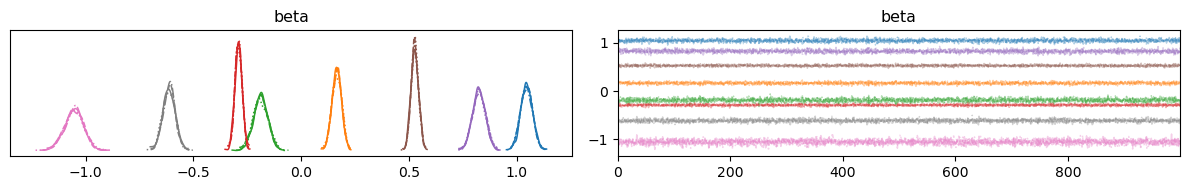

In [19]:
az.plot_trace(post_pred.posterior_az, var_names = ['beta'])
plt.tight_layout()
plt.show()

In [20]:
waic_out = az.waic(post_pred.posterior_az, var_name='log_lik')
loo_out = az.loo(post_pred.posterior_az, var_name='log_lik')
waic = waic_out.elpd_waic
loo = loo_out.elpd_loo
print(waic_out)
print(loo_out)

C:\Users\39339\anaconda3\lib\site-packages\arviz\stats\stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


Computed from 4000 posterior samples and 3808 observations log-likelihood matrix.

          Estimate       SE
elpd_waic -5432.21   117.17
p_waic       26.95        -

There has been a warning during the calculation. Please check the results.
Computed from 4000 posterior samples and 3808 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -5432.26   117.18
p_loo       26.99        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     3808  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%



In [21]:
alpha = 0.05
y_pred, metrics = post_pred.predict(CI=True,
                                       alpha = alpha,
                                       error_metrics = True)

In [22]:
y_obs, residuals, mse, mae, mad, outliers, percentage_inside = metrics.values()
print(f'Outliers:\n{outliers}\n')
print(f'The total number of outliers is: {len(outliers)}\n')
print(f'The MSE is: {mse}\n')
print(f'The MAE is: {mae}\n')
print(f'The MAD is: {mad}\n')
print(f'The percentage of observations inside the CI is: {percentage_inside}\n')

Outliers:
[   2   36   37   51   74   84   85  100  150  155  193  225  238  310
  324  330  331  346  347  371  372  376  378  383  384  389  390  402
  403  475  496  516  523  580  587  599  600  601  602  607  613  620
  621  622  628  630  634  636  642  643  644  648  649  656  676  677
  723  747  753  766  778  791  798  829  835  851  867  872  873  874
  907  914  925  926  931  932  944  950  951  955  956  957  963  969
  970  977  983  990  991  992  998 1038 1049 1050 1057 1063 1064 1065
 1070 1071 1072 1077 1078 1093 1094 1099 1112 1113 1114 1120 1122 1126
 1128 1133 1134 1135 1156 1168 1202 1203 1204 1217 1218 1366 1378 1379
 1380 1392 1427 1468 1539 1545 1558 1559 1560 1566 1568 1571 1572 1573
 1574 1580 1581 1582 1627 1658 1709 1710 1715 1716 1742 1743 1749 1754
 1761 1768 1773 1774 1779 1780 1781 1794 1800 1821 1832 1854 1867 1878
 1908 1921 1935 2010 2031 2045 2051 2052 2068 2074 2080 2081 2082 2093
 2094 2095 2107 2108 2110 2127 2135 2136 2152 2158 2165 2171 2193 2

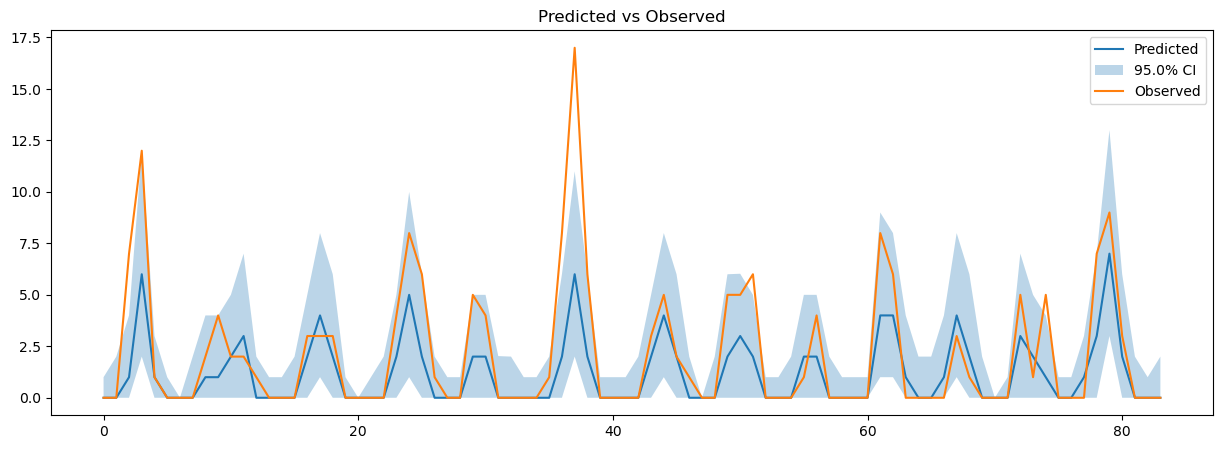

In [23]:
station_num_to_plot = 1 # Change this to plot a different station, -1 to plot manually
if station_num_to_plot != -1:
    xx = np.arange(12*7*(station_num_to_plot-1), 12*7*station_num_to_plot)
else:
    xx = np.arange(1000, 1200) # Change this for the range of the manual choice
plt.figure(figsize=(15, 5))
plt.plot(xx, y_pred.loc[xx, 'pred'], label='Predicted')
plt.fill_between(xx, y_pred.loc[xx, f'{alpha/2}'], y_pred.loc[xx, f'{(1-alpha/2)}'], alpha=0.3, label=f'{(1-alpha)*100}% CI')
plt.plot(xx, Y_data[xx], label='Observed')
plt.legend()
plt.title('Predicted vs Observed')
plt.show()

In [24]:
Model_metrics.loc['Variable Selection',:] = [waic, loo, mse, mae, mad, percentage_inside]
print(Model_metrics)

                           WAIC          LOO       MSE       MAE  MAD  \
Base               -5431.951611 -5432.002558  5.273241  1.178834  0.0   
Variable Selection -5432.213901 -5432.256854  5.289719  1.178178  0.0   

                   inside CI  
Base                0.918067  
Variable Selection  0.916492  


# Year model
We add the factor accounting for different years.

In [25]:
model_years = FetchModel("years").compile()

In [26]:
data_years = {
    "N": len(Y_obs),
    "P": X_obs.shape[1],
    "nyears": 13,
    "year": years_obs,
    "y": Y_obs['Count_180'],
    "X": X_obs
}

fit_years = model_years.sample(data=data_years, chains=4, parallel_chains=4, 
    iter_warmup=300, iter_sampling=200)
posterior_180_years = az.from_cmdstanpy(fit_years)

11:55:10 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:55:32 - cmdstanpy - INFO - CmdStan done processing.
11:55:32 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'years.stan', line 34, column 2 to column 27)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'years.stan', line 34, column 2 to column 27)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'years.stan', line 34, column 2 to column 27)
Consider re-running with show_console=True if the above output is unclear!


In [27]:
post_pred = PostPred(posterior_180_years, Y['Count_180'])
Y_data = post_pred.Y

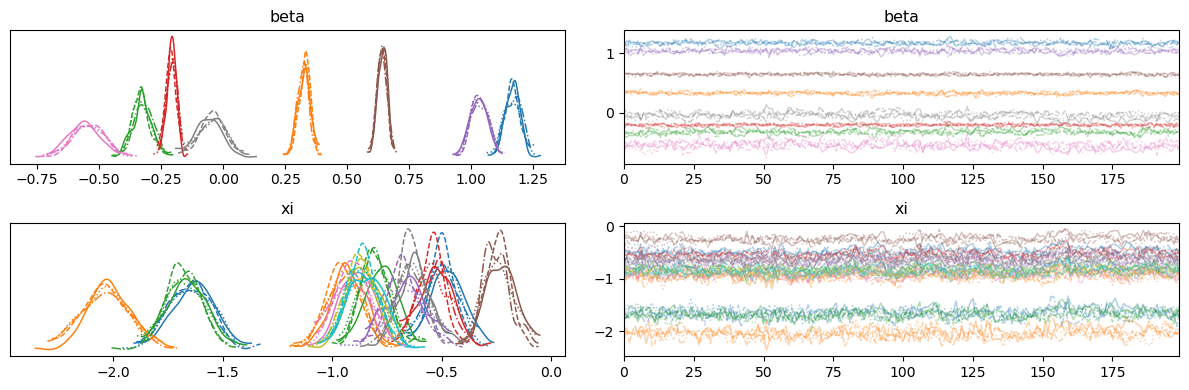

In [28]:
az.plot_trace(post_pred.posterior_az, var_names = ['beta', 'xi'])
plt.tight_layout()
plt.show()

In [29]:
waic_out = az.waic(post_pred.posterior_az, var_name='log_lik')
loo_out = az.loo(post_pred.posterior_az, var_name='log_lik')
waic = waic_out.elpd_waic
loo = loo_out.elpd_loo
print(waic_out)
print(loo_out)

C:\Users\39339\anaconda3\lib\site-packages\arviz\stats\stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


Computed from 800 posterior samples and 3808 observations log-likelihood matrix.

          Estimate       SE
elpd_waic -4813.53   110.28
p_waic       56.62        -

There has been a warning during the calculation. Please check the results.
Computed from 800 posterior samples and 3808 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -4813.78   110.28
p_loo       56.87        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     3806   99.9%
 (0.5, 0.7]   (ok)          2    0.1%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%



In [30]:
alpha = 0.05
y_pred, metrics = post_pred.predict(CI=True,
                                       alpha = alpha,
                                       error_metrics = True)

In [31]:
y_obs, residuals, mse, mae, mad, outliers, percentage_inside = metrics.values()
print(f'Outliers:\n{outliers}\n')
print(f'The total number of outliers is: {len(outliers)}\n')
print(f'The MSE is: {mse}\n')
print(f'The MAE is: {mae}\n')
print(f'The MAD is: {mad}\n')
print(f'The percentage of observations inside the CI is: {percentage_inside}\n')

Outliers:
[   2    9   72   74   78  125  150  193  205  233  238  259  299  324
  330  337  339  346  347  371  372  378  383  384  402  403  415  428
  435  449  516  523  593  596  600  601  602  607  613  620  621  622
  628  630  642  643  644  649  656  658  676  723  778  779  798  851
  867  872  873  914  925  926  931  932  943  944  945  950  955  956
  957  963  969  970  990  991  998 1025 1038 1050 1077 1084 1093 1094
 1112 1113 1114 1119 1120 1122 1128 1133 1134 1135 1156 1157 1161 1162
 1168 1183 1262 1366 1394 1427 1539 1558 1559 1560 1566 1568 1574 1580
 1581 1582 1632 1658 1780 1800 1820 1821 1878 1935 1963 1995 1996 2010
 2011 2051 2052 2068 2074 2080 2081 2082 2094 2095 2107 2108 2110 2115
 2127 2128 2130 2135 2139 2152 2158 2171 2216 2235 2240 2248 2261 2295
 2314 2331 2338 2344 2349 2350 2363 2371 2384 2389 2440 2449 2473 2479
 2552 2553 2559 2561 2562 2563 2567 2568 2569 2574 2575 2613 2614 2621
 2646 2647 2649 2650 2670 2672 2680 2699 2705 2726 2757 2808 2809 2

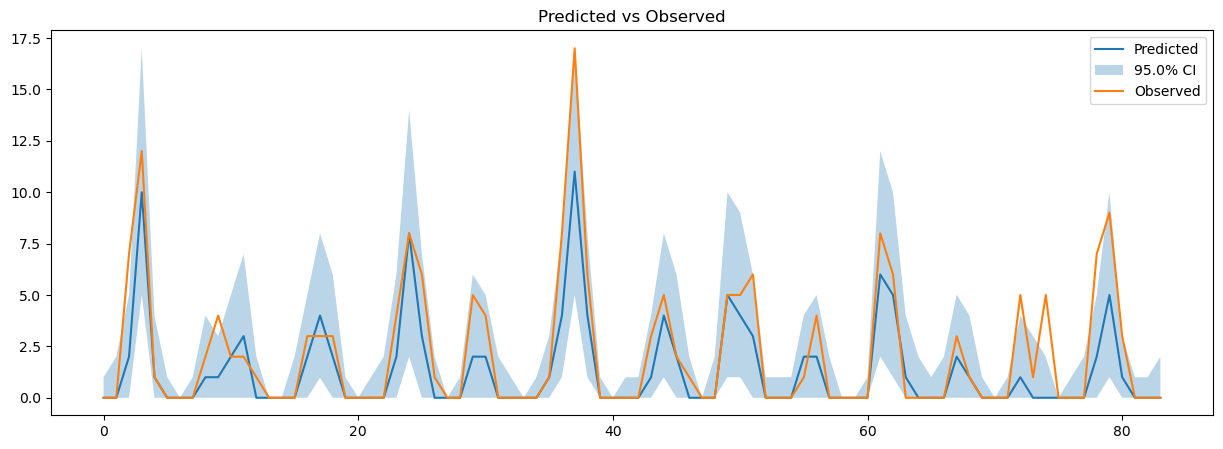

In [32]:
station_num_to_plot = 1 # Change this to plot a different station, -1 to plot manually
if station_num_to_plot != -1:
    xx = np.arange(12*7*(station_num_to_plot-1), 12*7*station_num_to_plot)
else:
    xx = np.arange(1000, 1200) # Change this for the range of the manual choice
plt.figure(figsize=(15, 5))
plt.plot(xx, y_pred.loc[xx, 'pred'], label='Predicted')
plt.fill_between(xx, y_pred.loc[xx, f'{alpha/2}'], y_pred.loc[xx, f'{(1-alpha/2)}'], alpha=0.3, label=f'{(1-alpha)*100}% CI')
plt.plot(xx, Y_data[xx], label='Observed')
plt.legend()
plt.title('Predicted vs Observed')
plt.show()

In [33]:
Model_metrics.loc['Years',:] = [waic, loo, mse, mae, mad, percentage_inside]
print(Model_metrics)

                           WAIC          LOO       MSE       MAE  MAD  \
Base               -5431.951611 -5432.002558  5.273241  1.178834  0.0   
Variable Selection -5432.213901 -5432.256854  5.289719  1.178178  0.0   
Years              -4813.533794 -4813.781316  4.025341  1.000788  0.0   

                   inside CI  
Base                0.918067  
Variable Selection  0.916492  
Years               0.932511  


# Stations factor

After this upgrade, we account for the differences in the *stations* factor.

In [34]:
model_stations = FetchModel("stations").compile()

In [35]:
data_stations = {
    "N": len(Y_obs),
    "P": X_obs.shape[1],
    "nyears": 13,
    "nstations": 45,
    "stations": stations_obs,
    "year": years_obs,
    "y": Y_obs['Count_180'],
    "X": X_obs
}

fit_stations = model_stations.sample(data=data_stations, chains=4, parallel_chains=4, 
    iter_warmup=1000, iter_sampling=1000)
posterior_180_stations = az.from_cmdstanpy(fit_stations)

12:00:26 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

12:04:16 - cmdstanpy - INFO - CmdStan done processing.
12:04:16 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'stations.stan', line 35, column 2 to column 31)
Consider re-running with show_console=True if the above output is unclear!


In [36]:
post_pred = PostPred(posterior_180_stations, Y['Count_180'])
Y_data = post_pred.Y

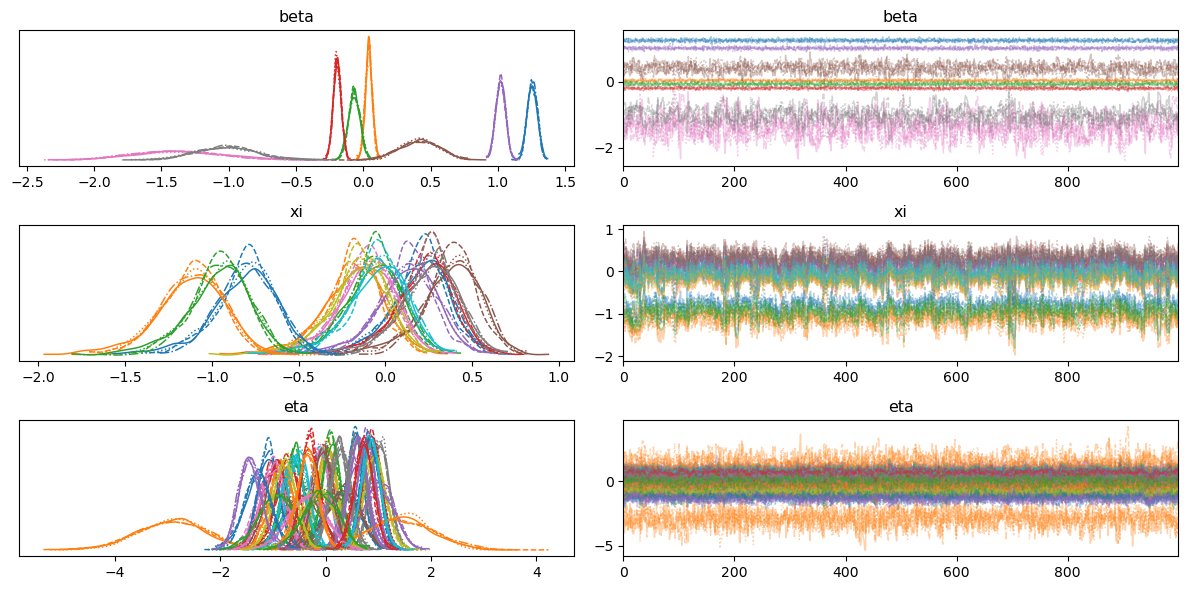

In [37]:
az.plot_trace(post_pred.posterior_az, var_names = ['beta', 'xi', 'eta'])
plt.tight_layout()
plt.show()

In [38]:
waic_out = az.waic(post_pred.posterior_az, var_name='log_lik')
loo_out = az.loo(post_pred.posterior_az, var_name='log_lik')
waic = waic_out.elpd_waic
loo = loo_out.elpd_loo
print(waic_out)
print(loo_out)

C:\Users\39339\anaconda3\lib\site-packages\arviz\stats\stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


Computed from 4000 posterior samples and 3808 observations log-likelihood matrix.

          Estimate       SE
elpd_waic -3838.39    84.65
p_waic      103.62        -

There has been a warning during the calculation. Please check the results.
Computed from 4000 posterior samples and 3808 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -3838.98    84.68
p_loo      104.21        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     3806   99.9%
 (0.5, 0.7]   (ok)          2    0.1%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%



In [39]:
eta = post_pred.posterior.eta
eta
len(np.unique(stations))

45

In [40]:
lam = post_pred.posterior['lambda']

In [41]:
inference = []
for i in range(len(np.unique(stations_obs))):
    ar1 = eta[0, :, i]
    ar2 = eta[1, :, i]
    ar3 = eta[2, :, i]
    ar4 = eta[3, :, i]
    current_iteration_df = np.concatenate((ar1, ar2, ar3, ar4), axis=0)
    inference.append(current_iteration_df)

len(current_iteration_df)
len(inference)

45

In [42]:
inference_lam = []
for i in range(len(Y_obs['Count_180'])):
    ar1 = lam[0, :, i]-Y_obs['Count_180'][i]
    ar2 = lam[1, :, i]-Y_obs['Count_180'][i]
    ar3 = lam[2, :, i]-Y_obs['Count_180'][i]
    ar4 = lam[3, :, i]-Y_obs['Count_180'][i]
    current_iteration_df = np.concatenate((ar1, ar2, ar3, ar4), axis=0)
    inference_lam.append(current_iteration_df)

In [43]:
df = pd.DataFrame(inference).transpose()
df.shape
df.columns = np.unique(stations_original[idx_obs])
df.columns.values

array([ 5707,  5710,  5717,  5718,  5719,  5721,  5725,  5730,  5732,
        5735,  5738,  5739,  5742,  5749,  5750,  5952,  5960,  6582,
        6665,  6691,  6804,  6818,  6832,  6884,  6904,  9856,  9861,
        9882,  9899,  9925,  9972,  9991,  9997, 10025, 10041, 10081,
       10171, 10270, 10282, 10288, 10437, 10454, 10463, 10584, 12020],
      dtype=int64)

In [44]:
df_lam = pd.DataFrame(inference_lam).transpose()
df_lam.shape
df_lam.columns.values

array([   0,    1,    2, ..., 3805, 3806, 3807], dtype=int64)

In [45]:
import os
if not os.path.exists('../Datasets/Space_estimate'):
    os.makedirs('../Datasets/Space_estimate')

csv_path = '../Datasets/Space_estimate/eta_180.csv'
data = pd.DataFrame(df)
data.to_csv(csv_path, index=False)

csv_path = '../Datasets/Space_estimate/res_180.csv'
data = pd.DataFrame(df_lam)
data.to_csv(csv_path, index=False)

In [46]:
alpha = 0.05
y_pred, metrics = post_pred.predict(CI=True,
                                       alpha = alpha,
                                       error_metrics = True)

In [47]:
y_obs, residuals, mse, mae, mad, outliers, percentage_inside = metrics.values()
print(f'Outliers:\n{outliers}\n')
print(f'The total number of outliers is: {len(outliers)}\n')
print(f'The MSE is: {mse}\n')
print(f'The MAE is: {mae}\n')
print(f'The MAD is: {mad}\n')
print(f'The percentage of observations inside the CI is: {percentage_inside}\n')

Outliers:
[  74   78  125  150  160  187  193  233  365  372  384  402  403  441
  474  475  529  579  602  656  675  676  677  778  798  851  867  872
  873  907 1043 1078 1093 1122 1156 1157 1262 1337 1366 1380 1394 1427
 1524 1532 1539 1568 1618 1658 1748 1780 1813 1821 1832 1878 1935 1973
 2110 2127 2135 2224 2240 2331 2338 2371 2377 2389 2440 2449 2458 2492
 2518 2532 2561 2562 2569 2650 2672 2679 2691 2705 2725 2750 2769 2817
 2829 2851 2877 2879 2911 2997 3044 3087 3100 3220 3222 3226 3227 3260
 3272 3330 3361 3375 3400 3401 3443 3486 3507 3560 3610 3626 3663 3668
 3723 3743 3770]

The total number of outliers is: 115

The MSE is: 2.2605042016806722

The MAE is: 0.7226890756302521

The MAD is: 0.0

The percentage of observations inside the CI is: 0.9698004201680672



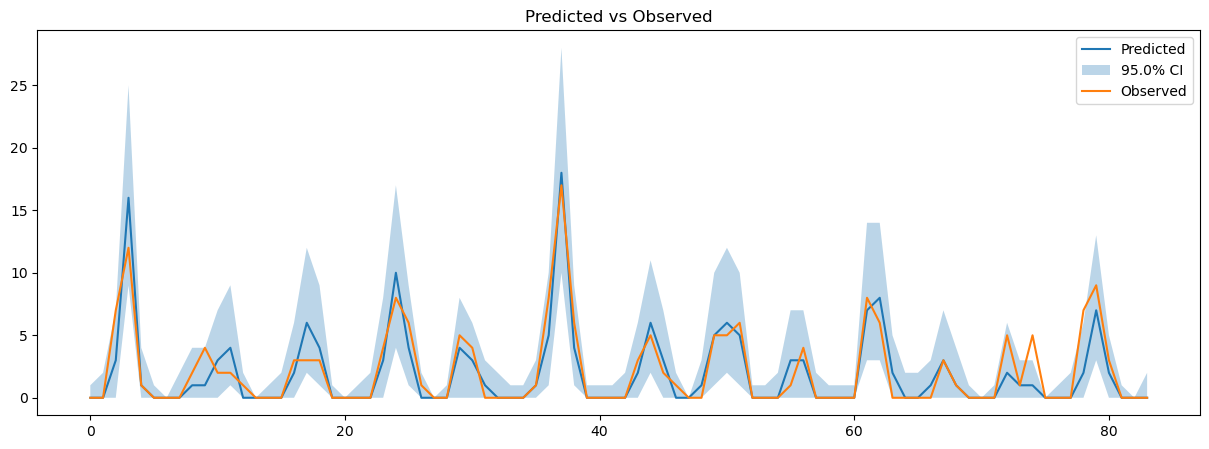

In [48]:
station_num_to_plot = 1 # Change this to plot a different station, -1 to plot manually
if station_num_to_plot != -1:
    xx = np.arange(12*7*(station_num_to_plot-1), 12*7*station_num_to_plot)
else:
    xx = np.arange(1000, 1200) # Change this for the range of the manual choice
plt.figure(figsize=(15, 5))
plt.plot(xx, y_pred.loc[xx, 'pred'], label='Predicted')
plt.fill_between(xx, y_pred.loc[xx, f'{alpha/2}'], y_pred.loc[xx, f'{(1-alpha/2)}'], alpha=0.3, label=f'{(1-alpha)*100}% CI')
plt.plot(xx, Y_data[xx], label='Observed')
plt.legend()
plt.title('Predicted vs Observed')
plt.show()


In [49]:
Model_metrics.loc['Stations',:] = [waic, loo, mse, mae, mad, percentage_inside]
print(Model_metrics)

                           WAIC          LOO       MSE       MAE  MAD  \
Base               -5431.951611 -5432.002558  5.273241  1.178834  0.0   
Variable Selection -5432.213901 -5432.256854  5.289719  1.178178  0.0   
Years              -4813.533794 -4813.781316  4.025341  1.000788  0.0   
Stations           -3838.386982 -3838.976615  2.260504  0.722689  0.0   

                   inside CI  
Base                0.918067  
Variable Selection  0.916492  
Years               0.932511  
Stations              0.9698  


# Space model

Now, we should take into account the spatial dependance of the model, through an appropriate space model (main folder with R files) and put again this ideas into this model.

In [50]:
phi = 63
distances = pd.read_csv("../Datasets/distances.csv", index_col=0)

In [51]:
model_space = FetchModel("space").compile()

12:08:29 - cmdstanpy - INFO - compiling stan file C:\Users\39339\OneDrive\Desktop\ISEMES~1\BAYESI~2\main\Modello\stan\space.stan to exe file C:\Users\39339\OneDrive\Desktop\I semestre\Bayesian_Project\main\Modello\stan\space.exe
12:11:12 - cmdstanpy - INFO - compiled model executable: C:\Users\39339\OneDrive\Desktop\I semestre\Bayesian_Project\main\Modello\stan\space.exe


In [52]:
data_space = {
    "N": len(Y_obs),
    "P": X_obs.shape[1],
    "nyears": 13,
    "nstations": 45,
    "stations": stations_obs,
    "year": years_obs,
    "y": Y_obs['Count_180'],
    "X": X_obs,
    "phi": phi,
    "distances": distances
}

fit_space = model_space.sample(data=data_space, chains=4, parallel_chains=4, 
    iter_warmup=1000, iter_sampling=1000)
posterior_180_space = az.from_cmdstanpy(fit_space)

12:11:14 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

12:19:00 - cmdstanpy - INFO - CmdStan done processing.
12:19:01 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf (in 'space.stan', line 34, column 4 to column 65)
	Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf (in 'space.stan', line 34, column 4 to column 65)
	Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf (in 'space.stan', line 34, column 4 to column 65)
	Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf (in 'space.stan', line 34, column 4 to column 65)
Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf (in 'space.stan', line 34, column 4 to column 65)
	Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf (in 'space.stan', line 34, column 4 to column 65)
	Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf 

In [53]:
post_pred = PostPred(posterior_180_space, Y['Count_180'])
Y_data = post_pred.Y

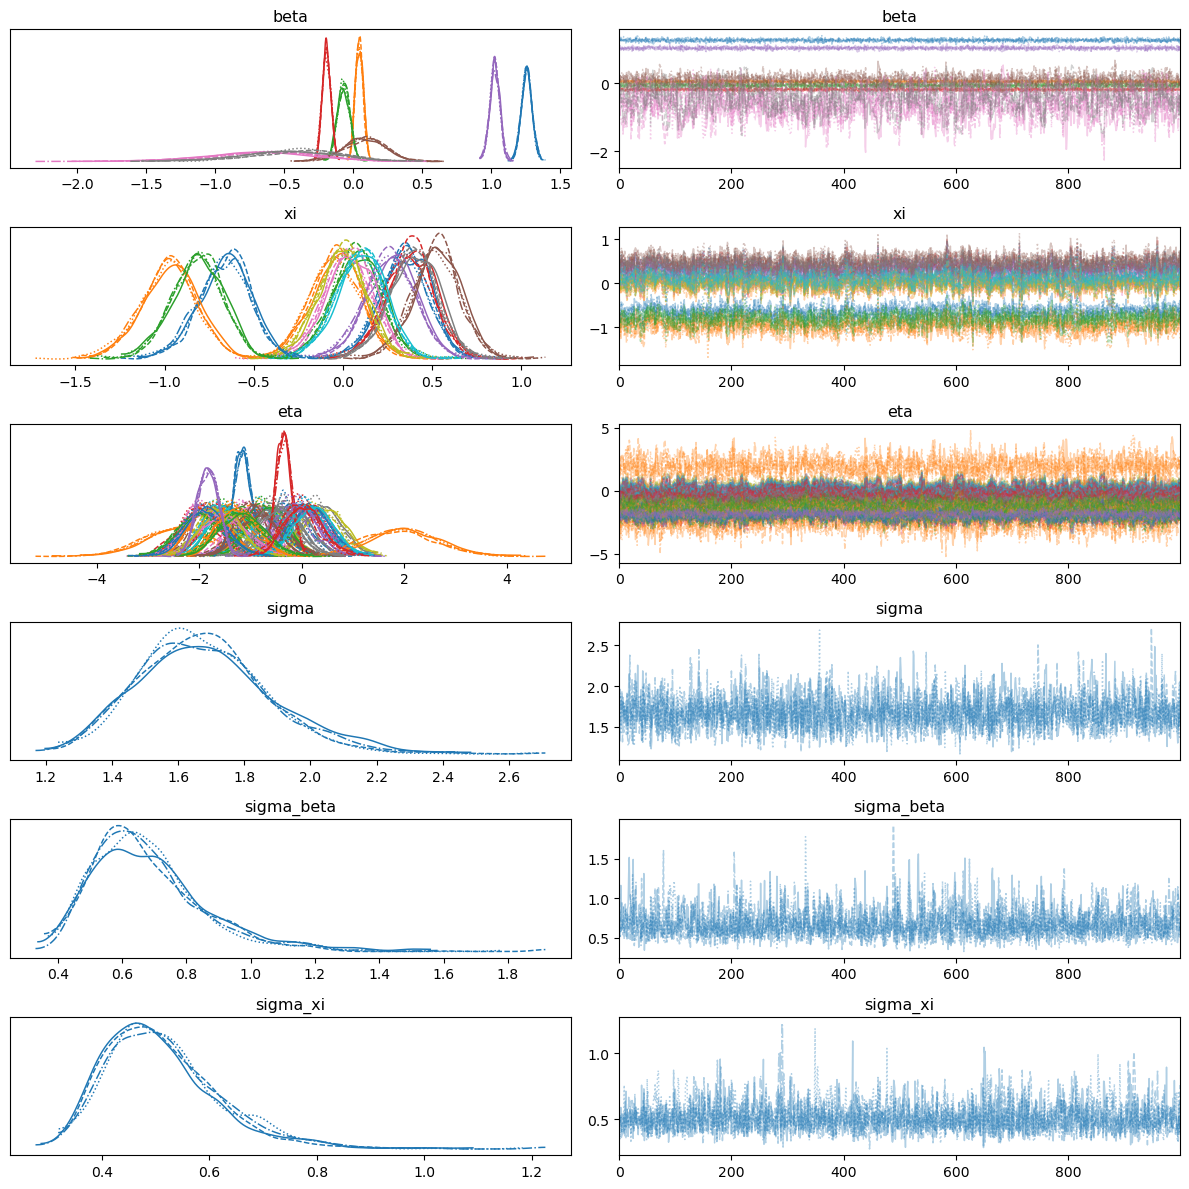

In [54]:
az.plot_trace(post_pred.posterior_az, var_names = ['beta', 'xi', 'eta', 'sigma', 'sigma_beta', 'sigma_xi'])
plt.tight_layout()
plt.show()

In [55]:
waic_out = az.waic(post_pred.posterior_az, var_name='log_lik')
loo_out = az.loo(post_pred.posterior_az, var_name='log_lik')
waic = waic_out.elpd_waic
loo = loo_out.elpd_loo
print(waic_out)
print(loo_out)

C:\Users\39339\anaconda3\lib\site-packages\arviz\stats\stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


Computed from 4000 posterior samples and 3808 observations log-likelihood matrix.

          Estimate       SE
elpd_waic -3837.95    84.75
p_waic      103.14        -

There has been a warning during the calculation. Please check the results.
Computed from 4000 posterior samples and 3808 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -3838.47    84.77
p_loo      103.66        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     3806   99.9%
 (0.5, 0.7]   (ok)          2    0.1%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%



In [56]:
alpha = 0.05
y_pred, metrics = post_pred.predict(CI=True,
                                       alpha = alpha,
                                       error_metrics = True)

In [57]:
y_obs, residuals, mse, mae, mad, outliers, percentage_inside = metrics.values()
print(f'Outliers:\n{outliers}\n')
print(f'The total number of outliers is: {len(outliers)}\n')
print(f'The MSE is: {mse}\n')
print(f'The MAE is: {mae}\n')
print(f'The MAD is: {mad}\n')
print(f'The percentage of observations inside the CI is: {percentage_inside}\n')

Outliers:
[  74   78   84  125  150  160  187  193  233  365  372  384  402  403
  441  474  475  529  579  602  656  675  676  677  778  798  851  867
  872  873  907 1078 1093 1122 1156 1157 1262 1337 1366 1380 1394 1427
 1524 1532 1539 1568 1618 1658 1748 1780 1813 1821 1832 1878 1935 1973
 2110 2127 2135 2224 2240 2331 2338 2371 2377 2389 2440 2449 2458 2492
 2518 2532 2561 2562 2569 2615 2650 2672 2679 2691 2705 2725 2750 2769
 2817 2822 2829 2851 2877 2879 2911 2997 3044 3087 3100 3185 3220 3222
 3226 3227 3260 3272 3330 3361 3375 3400 3401 3443 3486 3507 3560 3610
 3626 3663 3668 3723 3743 3770]

The total number of outliers is: 118

The MSE is: 2.24422268907563

The MAE is: 0.7205882352941176

The MAD is: 0.0

The percentage of observations inside the CI is: 0.9690126050420168



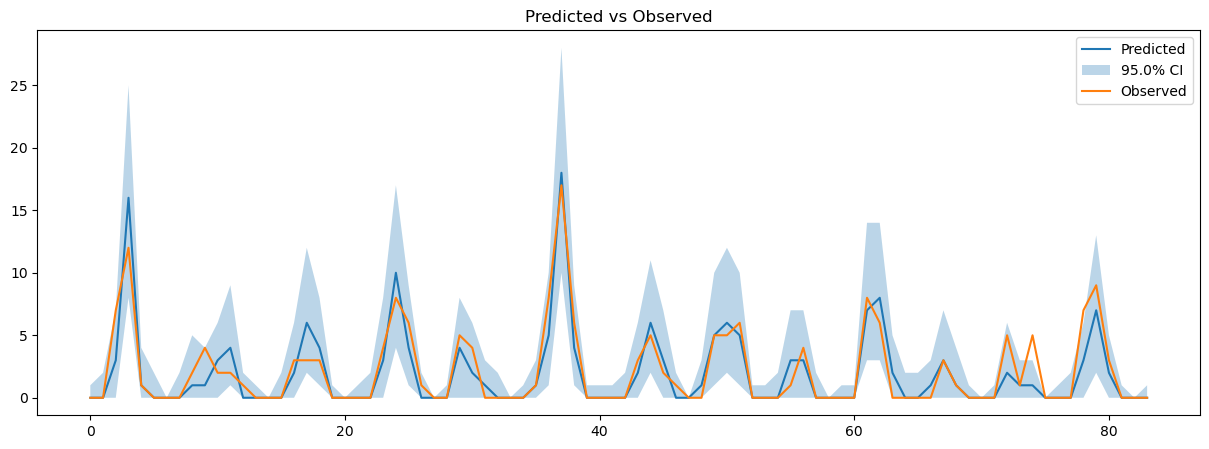

In [58]:
station_num_to_plot = 1 # Change this to plot a different station, -1 to plot manually
if station_num_to_plot != -1:
    xx = np.arange(12*7*(station_num_to_plot-1), 12*7*station_num_to_plot)
else:
    xx = np.arange(1000, 1200) # Change this for the range of the manual choice
plt.figure(figsize=(15, 5))
plt.plot(xx, y_pred.loc[xx, 'pred'], label='Predicted')
plt.fill_between(xx, y_pred.loc[xx, f'{alpha/2}'], y_pred.loc[xx, f'{(1-alpha/2)}'], alpha=0.3, label=f'{(1-alpha)*100}% CI')
plt.plot(xx, Y_data[xx], label='Observed')
plt.legend()
plt.title('Predicted vs Observed')
plt.show()

In [59]:
Model_metrics.loc['Spatial',:] = [waic, loo, mse, mae, mad, percentage_inside]
print(Model_metrics)

                           WAIC          LOO       MSE       MAE  MAD  \
Base               -5431.951611 -5432.002558  5.273241  1.178834  0.0   
Variable Selection -5432.213901 -5432.256854  5.289719  1.178178  0.0   
Years              -4813.533794 -4813.781316  4.025341  1.000788  0.0   
Stations           -3838.386982 -3838.976615  2.260504  0.722689  0.0   
Spatial            -3837.953368 -3838.473196  2.244223  0.720588  0.0   

                   inside CI  
Base                0.918067  
Variable Selection  0.916492  
Years               0.932511  
Stations              0.9698  
Spatial             0.969013  


In [60]:
model_space_bis = FetchModel("space_bis").compile()

12:21:20 - cmdstanpy - INFO - compiling stan file C:\Users\39339\OneDrive\Desktop\ISEMES~1\BAYESI~2\main\Modello\stan\space_bis.stan to exe file C:\Users\39339\OneDrive\Desktop\I semestre\Bayesian_Project\main\Modello\stan\space_bis.exe
12:23:32 - cmdstanpy - INFO - compiled model executable: C:\Users\39339\OneDrive\Desktop\I semestre\Bayesian_Project\main\Modello\stan\space_bis.exe


In [61]:
data_space_bis = {
    "N": len(Y_obs),
    "P": X_obs.shape[1],
    "nyears": 13,
    "nstations": 45,
    "station": stations_obs,
    "year": years_obs,
    "y": Y_obs['Count_180'],
    "X": X_obs,
    "phi": phi,
    "distances": distances
}

fit_space_bis = model_space_bis.sample(data=data_space_bis, chains=4, parallel_chains=4, 
    iter_warmup=1000, iter_sampling=1000)
posterior_180_space_bis = az.from_cmdstanpy(fit_space_bis)

12:23:34 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

12:29:25 - cmdstanpy - INFO - CmdStan done processing.
12:29:25 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf (in 'space_bis.stan', line 36, column 4 to column 65)
Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf (in 'space_bis.stan', line 36, column 4 to column 65)
	Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf (in 'space_bis.stan', line 36, column 4 to column 65)
	Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf (in 'space_bis.stan', line 36, column 4 to column 65)
	Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf (in 'space_bis.stan', line 36, column 4 to column 65)
	Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf (in 'space_bis.stan', line 36, column 4 to column 65)
Exception: cholesky_decompose: A is not symmetric. A[1,2] =

In [62]:
post_pred = PostPred(posterior_180_space_bis, Y['Count_180'])
Y_data = post_pred.Y
post_pred.posterior_az

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats

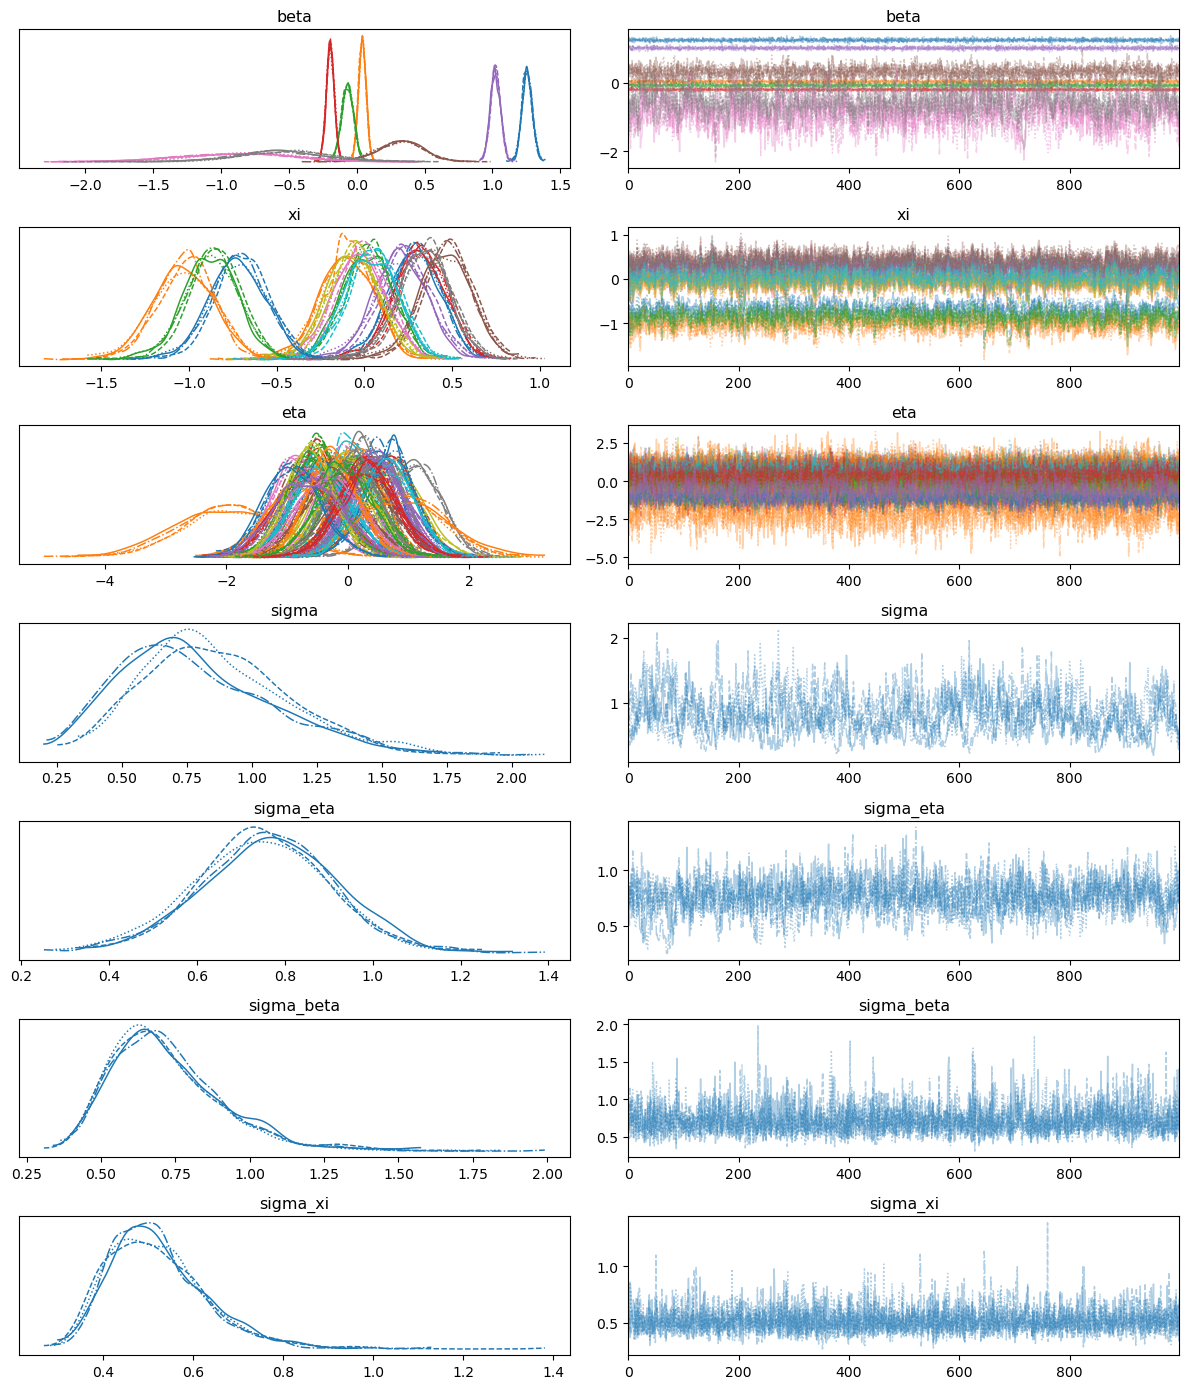

In [63]:
az.plot_trace(post_pred.posterior_az, var_names = ['beta', 'xi', 'eta', 'sigma', 'sigma_eta', 'sigma_beta', 'sigma_xi'])
plt.tight_layout()
plt.show()

In [64]:
waic_out = az.waic(post_pred.posterior_az, var_name='log_lik')
loo_out = az.loo(post_pred.posterior_az, var_name='log_lik')
waic = waic_out.elpd_waic
loo = loo_out.elpd_loo
print(waic_out)
print(loo_out)

C:\Users\39339\anaconda3\lib\site-packages\arviz\stats\stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


Computed from 4000 posterior samples and 3808 observations log-likelihood matrix.

          Estimate       SE
elpd_waic -3838.12    84.70
p_waic      103.66        -

There has been a warning during the calculation. Please check the results.
Computed from 4000 posterior samples and 3808 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -3838.63    84.72
p_loo      104.18        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     3807  100.0%
 (0.5, 0.7]   (ok)          1    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%



In [65]:
alpha = 0.05
y_pred, metrics = post_pred.predict(CI=True,
                                       alpha = alpha,
                                       error_metrics = True)

In [66]:
y_obs, residuals, mse, mae, mad, outliers, percentage_inside = metrics.values()
print(f'Outliers:\n{outliers}\n')
print(f'The total number of outliers is: {len(outliers)}\n')
print(f'The MSE is: {mse}\n')
print(f'The MAE is: {mae}\n')
print(f'The MAD is: {mad}\n')
print(f'The percentage of observations inside the CI is: {percentage_inside}\n')

Outliers:
[  74   78  125  150  160  187  193  233  365  372  384  402  403  441
  474  475  529  579  602  656  675  676  677  778  798  851  867  872
  873  907 1043 1078 1093 1122 1156 1157 1262 1337 1366 1394 1427 1524
 1532 1539 1568 1618 1619 1658 1748 1780 1813 1821 1832 1878 1935 1973
 2110 2127 2135 2158 2224 2240 2331 2338 2371 2377 2389 2440 2449 2458
 2492 2518 2532 2561 2562 2569 2615 2650 2672 2679 2691 2705 2725 2738
 2750 2769 2817 2829 2851 2877 2879 2911 2997 3030 3044 3087 3100 3220
 3222 3226 3227 3252 3260 3272 3330 3361 3375 3400 3401 3443 3486 3507
 3560 3610 3626 3663 3743 3770]

The total number of outliers is: 118

The MSE is: 2.264705882352941

The MAE is: 0.7224264705882353

The MAD is: 0.0

The percentage of observations inside the CI is: 0.9690126050420168



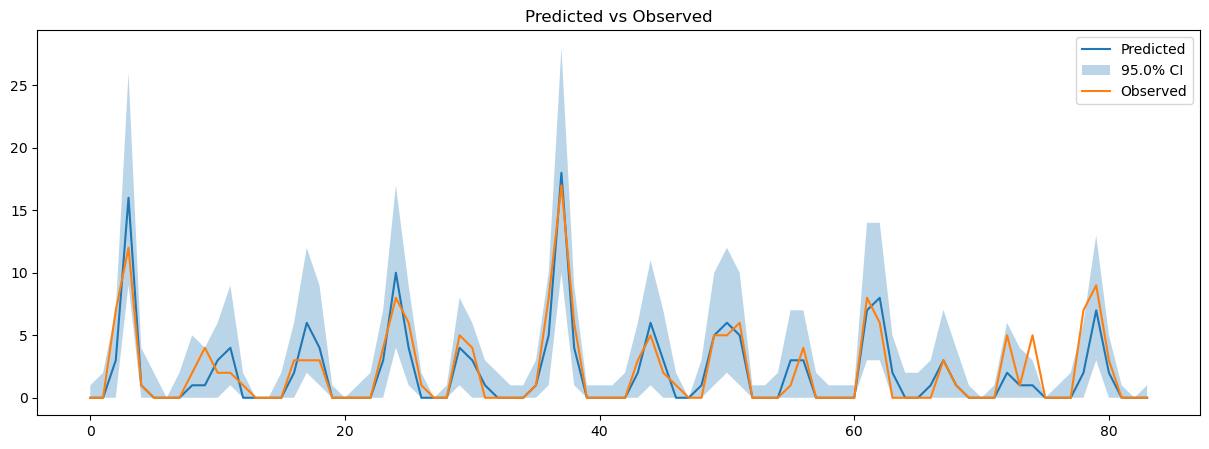

In [67]:
station_num_to_plot = 1 # Change this to plot a different station, -1 to plot manually
if station_num_to_plot != -1:
    xx = np.arange(12*7*(station_num_to_plot-1), 12*7*station_num_to_plot)
else:
    xx = np.arange(1000, 1200) # Change this for the range of the manual choice
plt.figure(figsize=(15, 5))
plt.plot(xx, y_pred.loc[xx, 'pred'], label='Predicted')
plt.fill_between(xx, y_pred.loc[xx, f'{alpha/2}'], y_pred.loc[xx, f'{(1-alpha/2)}'], alpha=0.3, label=f'{(1-alpha)*100}% CI')
plt.plot(xx, Y_data[xx], label='Observed')
plt.legend()
plt.title('Predicted vs Observed')
plt.show()

In [68]:
Model_metrics.loc['Spatial 2',:] = [waic, loo, mse, mae, mad, percentage_inside]
print(Model_metrics)

                           WAIC          LOO       MSE       MAE  MAD  \
Base               -5431.951611 -5432.002558  5.273241  1.178834  0.0   
Variable Selection -5432.213901 -5432.256854  5.289719  1.178178  0.0   
Years              -4813.533794 -4813.781316  4.025341  1.000788  0.0   
Stations           -3838.386982 -3838.976615  2.260504  0.722689  0.0   
Spatial            -3837.953368 -3838.473196  2.244223  0.720588  0.0   
Spatial 2          -3838.117538 -3838.633899  2.264706  0.722426  0.0   

                   inside CI  
Base                0.918067  
Variable Selection  0.916492  
Years               0.932511  
Stations              0.9698  
Spatial             0.969013  
Spatial 2           0.969013  


# ZIP

In [69]:
model_zip = FetchModel("zip").compile()

12:30:36 - cmdstanpy - INFO - compiling stan file C:\Users\39339\OneDrive\Desktop\ISEMES~1\BAYESI~2\main\Modello\stan\zip.stan to exe file C:\Users\39339\OneDrive\Desktop\I semestre\Bayesian_Project\main\Modello\stan\zip.exe
12:31:50 - cmdstanpy - INFO - compiled model executable: C:\Users\39339\OneDrive\Desktop\I semestre\Bayesian_Project\main\Modello\stan\zip.exe


In [70]:
data_zip = {
    "N": len(Y_obs),
    "P": X_obs.shape[1],
    "nyears": 13,
    "nstations": 45,
    "stations": stations_obs,
    "year": years_obs,
    "y": Y_obs['Count_180'],
    "X": X_obs,
    "phi" : phi,
    "distances" : distances,
    "nmonths" : 7,
    "month" : months_obs
}

fit_zip = model_zip.sample(data=data_zip, chains=4, parallel_chains=4, 
    iter_warmup=1000, iter_sampling=1000)
posterior_180_zip = az.from_cmdstanpy(fit_zip)

12:31:52 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

12:41:51 - cmdstanpy - INFO - CmdStan done processing.
12:41:51 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf (in 'zip.stan', line 43, column 2 to column 63)
	Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf (in 'zip.stan', line 43, column 2 to column 63)
	Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf (in 'zip.stan', line 43, column 2 to column 63)
	Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf (in 'zip.stan', line 43, column 2 to column 63)
Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf (in 'zip.stan', line 43, column 2 to column 63)
	Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf (in 'zip.stan', line 43, column 2 to column 63)
Exception: cholesky_decompose: Matrix m is not positive definite (in 'zip.stan', line 43, colum

In [71]:
post_pred = PostPred(posterior_180_zip, Y['Count_180'])
Y_data = post_pred.Y
post_pred.posterior_az

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats

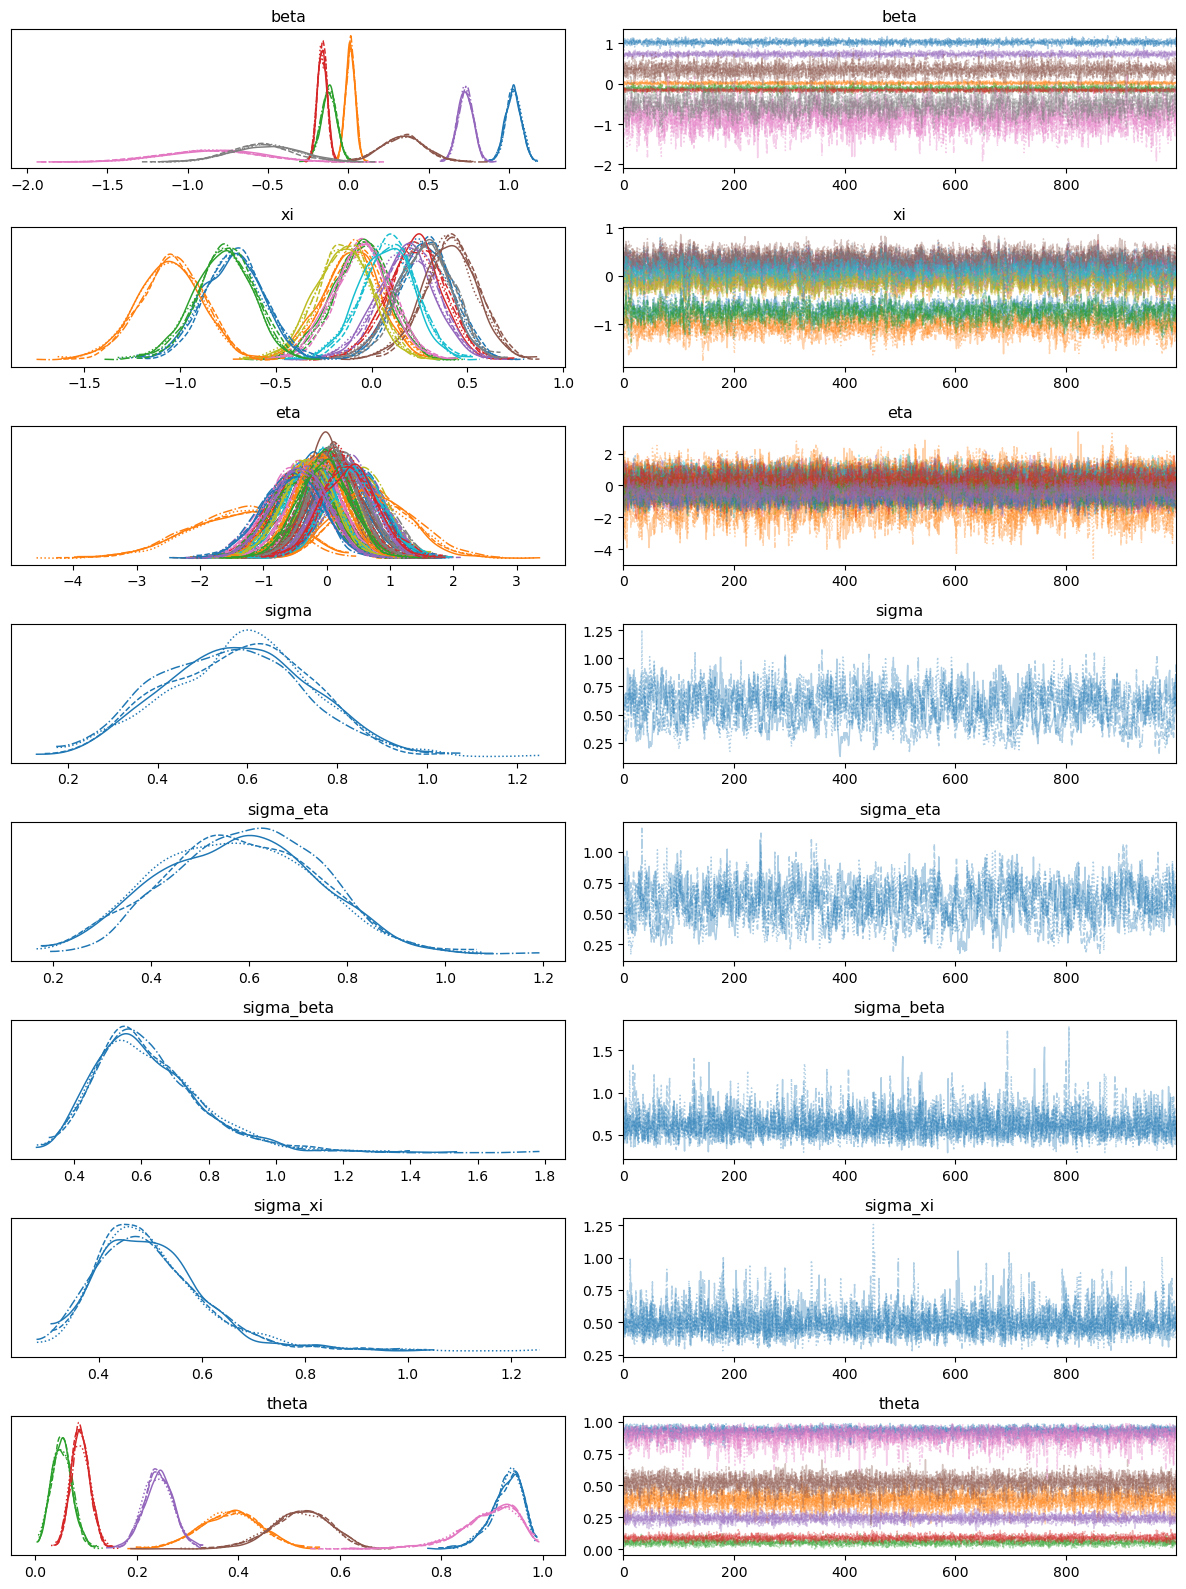

In [72]:
az.plot_trace(post_pred.posterior_az, var_names = ['beta', 'xi', 'eta', 'sigma', 'sigma_eta', 'sigma_beta', 'sigma_xi', 'theta'])
plt.tight_layout()
plt.show()

In [73]:
waic_out = az.waic(post_pred.posterior_az, var_name='log_lik')
loo_out = az.loo(post_pred.posterior_az, var_name='log_lik')
waic = waic_out.elpd_waic
loo = loo_out.elpd_loo
print(waic_out)
print(loo_out)

C:\Users\39339\anaconda3\lib\site-packages\arviz\stats\stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


Computed from 4000 posterior samples and 3808 observations log-likelihood matrix.

          Estimate       SE
elpd_waic -3712.24    78.55
p_waic       96.87        -

There has been a warning during the calculation. Please check the results.
Computed from 4000 posterior samples and 3808 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -3712.76    78.57
p_loo       97.38        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     3807  100.0%
 (0.5, 0.7]   (ok)          1    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%



In [74]:
alpha = 0.05
y_pred, metrics = post_pred.predict(CI=True,
                                       alpha = alpha,
                                       error_metrics = True)

In [75]:
y_obs, residuals, mse, mae, mad, outliers, percentage_inside = metrics.values()
print(f'Outliers:\n{outliers}\n')
print(f'The total number of outliers is: {len(outliers)}\n')
print(f'The MSE is: {mse}\n')
print(f'The MAE is: {mae}\n')
print(f'The MAD is: {mad}\n')
print(f'The percentage of observations inside the CI is: {percentage_inside}\n')

Outliers:
[  74  150  233  372  384  402  403  441  474  475  529  579  596  602
  656  676  798  851  872  873 1043 1093 1122 1156 1157 1262 1337 1366
 1539 1568 1658 1748 1813 1832 1878 1973 2110 2127 2135 2224 2240 2331
 2338 2371 2389 2440 2449 2518 2532 2563 2569 2672 2705 2750 2769 2851
 2877 2997 3087 3100 3220 3222 3324 3330 3400 3401 3443 3560 3610 3626
 3663 3722 3743]

The total number of outliers is: 73

The MSE is: 2.163668592436975

The MAE is: 0.7157300420168067

The MAD is: 0.0

The percentage of observations inside the CI is: 0.9808298319327731



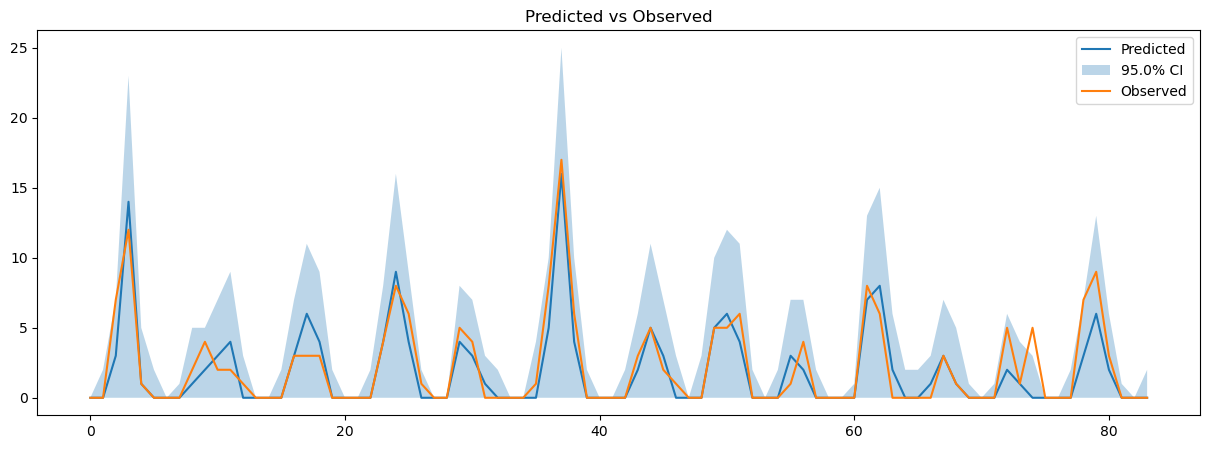

In [76]:
station_num_to_plot = 1 # Change this to plot a different station, -1 to plot manually
if station_num_to_plot != -1:
    xx = np.arange(12*7*(station_num_to_plot-1), 12*7*station_num_to_plot)
else:
    xx = np.arange(1000, 1200) # Change this for the range of the manual choice
plt.figure(figsize=(15, 5))
plt.plot(xx, y_pred.loc[xx, 'pred'], label='Predicted')
plt.fill_between(xx, y_pred.loc[xx, f'{alpha/2}'], y_pred.loc[xx, f'{(1-alpha/2)}'], alpha=0.3, label=f'{(1-alpha)*100}% CI')
plt.plot(xx, Y_data[xx], label='Observed')
plt.legend()
plt.title('Predicted vs Observed')
plt.show()

In [78]:
Model_metrics.loc['ZIP',:] = [waic, loo, mse, mae, mad, percentage_inside]
print(Model_metrics)

                           WAIC          LOO       MSE       MAE  MAD  \
Base               -5431.951611 -5432.002558  5.273241  1.178834  0.0   
Variable Selection -5432.213901 -5432.256854  5.289719  1.178178  0.0   
Years              -4813.533794 -4813.781316  4.025341  1.000788  0.0   
Stations           -3838.386982 -3838.976615  2.260504  0.722689  0.0   
Spatial            -3837.953368 -3838.473196  2.244223  0.720588  0.0   
Spatial 2          -3838.117538 -3838.633899  2.264706  0.722426  0.0   
ZIP                -3712.237216 -3712.756013  2.163669   0.71573  0.0   

                   inside CI  
Base                0.918067  
Variable Selection  0.916492  
Years               0.932511  
Stations              0.9698  
Spatial             0.969013  
Spatial 2           0.969013  
ZIP                  0.98083  
